<a href="https://colab.research.google.com/github/Matheus-Homem/international_bank_marketing/blob/main/notebooks/c2_metrics_and_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

## 0.1. Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
!pip install -U yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics as m
from plotly import express as px
!pip install umap-learn
import umap.umap_ as umap

## 0.2. Load Dataset

In [2]:
df = pd.read_csv('https://github.com/Matheus-Homem/international_bank_marketing/raw/main/data/CC%20GENERAL.csv')

In [3]:
df.sample().T

,721
CUST_ID,C10748
BALANCE,4881.82
BALANCE_FREQUENCY,1
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,223.953
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


# 1. Data Description

In [4]:
df1 = df.copy()

## 1.1. Rename Columns

In [5]:
df1.columns = list(map(lambda x: x.lower(), df1.columns))

## 1.2. Data Dimensions

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 8950
Number of columns: 18


## 1.3. Data Types

In [7]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4. Check NA

In [26]:
df1.isna().sum()

cust_id                             0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

In [16]:
df1['credit_limit'].fillna(df1['credit_limit'].min(),inplace=True)

In [23]:
df1['minimum_payments'].fillna(0,inplace=True)

## 1.5. Replace NA

In [9]:
# remove NA
df1.dropna(inplace=True)
print('Number of rows: {}'.format(df1.shape[0]))
print('Removed data: {:.2f}%'.format(1-(df1.shape[0]/df.shape[0])))

Number of rows: 8636
Removed data: 0.04%


## 1.6. Change dtypes

## 1.7. Descriptive Statistics

In [28]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [30]:
# Central Tendency -> Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion -> Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']
m

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,balance,0.0,19043.13856,19043.13856,1564.474828,873.385231,2081.415590,2.393386,7.674751
1,balance_frequency,0.0,1.00000,1.00000,0.877271,1.000000,0.236891,-2.023266,3.092370
2,purchases,0.0,49039.57000,49039.57000,1003.204834,361.280000,2136.515413,8.144269,111.388771
3,oneoff_purchases,0.0,40761.25000,40761.25000,592.437371,38.000000,1659.795184,10.045083,164.187572
4,installments_purchases,0.0,22500.00000,22500.00000,411.067645,89.000000,904.287592,7.299120,96.575178
5,cash_advance,0.0,47137.21176,47137.21176,978.871112,0.000000,2097.046713,5.166609,52.899434
6,purchases_frequency,0.0,1.00000,1.00000,0.490351,0.500000,0.401348,0.060164,-1.638631
7,oneoff_purchases_frequency,0.0,1.00000,1.00000,0.202458,0.083333,0.298319,1.535613,1.161846
8,purchases_installments_frequency,0.0,1.00000,1.00000,0.364437,0.166667,0.397426,0.509201,-1.398632
9,cash_advance_frequency,0.0,1.50000,1.50000,0.135144,0.000000,0.200110,1.828686,3.334734


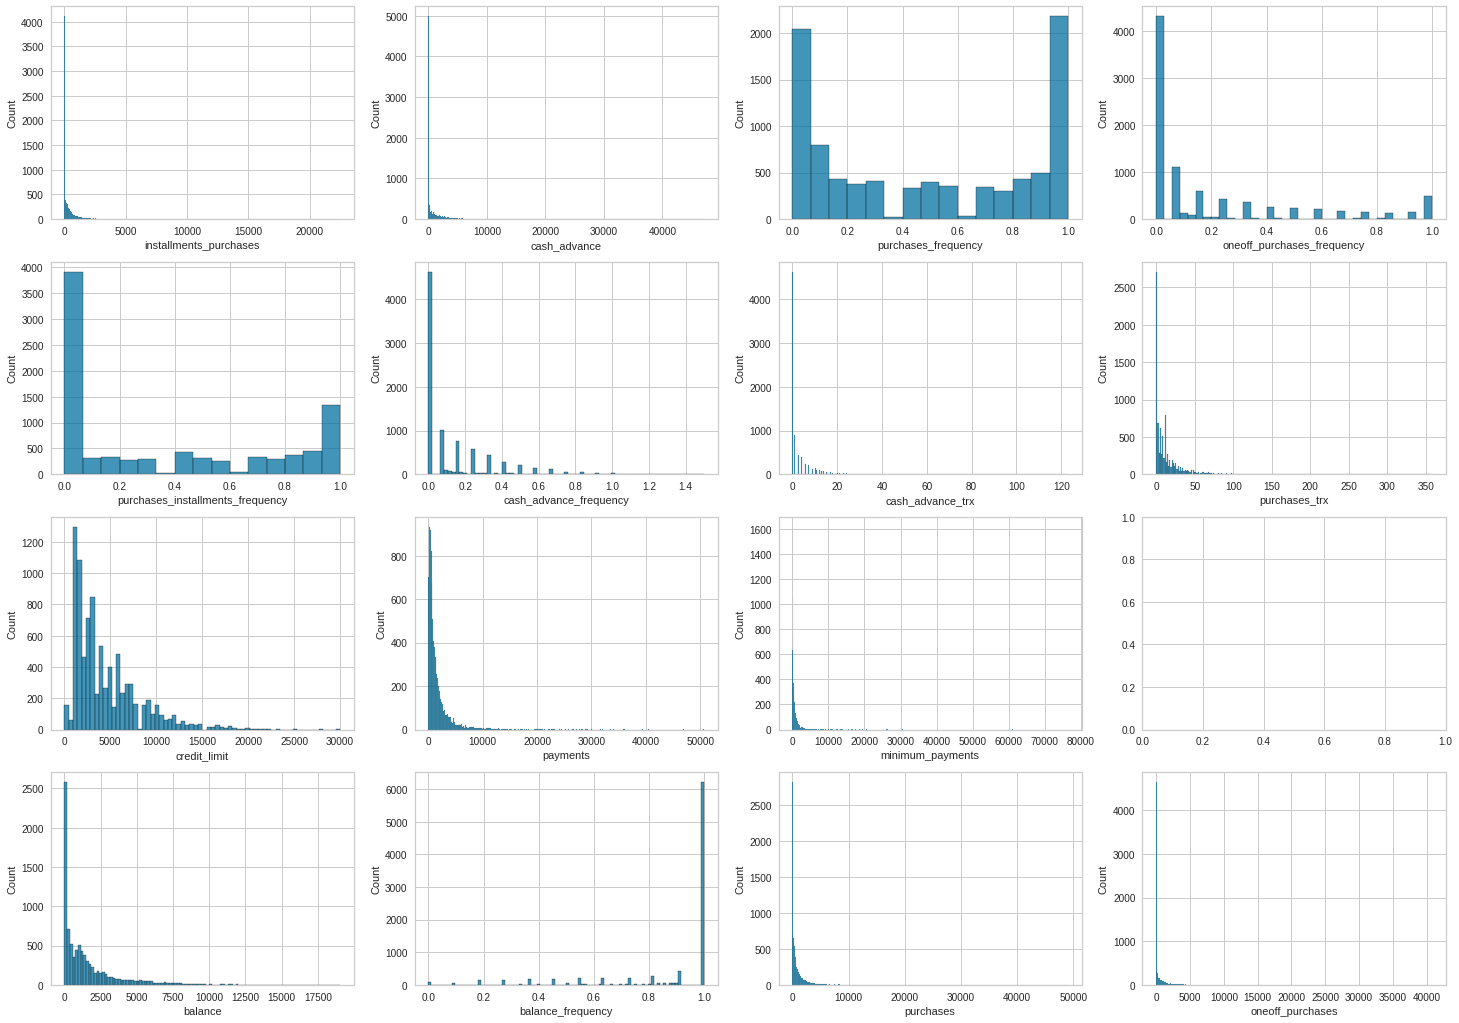

In [44]:
fig, ax = plt.subplots(4,4,figsize=(25,18))

features = num_attributes.drop('tenure',axis=1).columns
for k in range(15):
  q, mod = divmod(k,4)
  sns.histplot(data=df1,x=features[k],ax=ax[q-1][mod])

# 2. Feature Engineering

In [10]:
df2 = df1.copy()

## 2.1. Feature Creation

In [11]:
df2.sample(5).T

,386,5137,8750,3746,1355
cust_id,C10399,C15282,C18989,C13852,C11401
balance,1526.51,1033.37,8.34698,1253.72,920.872
balance_frequency,1,1,0.181818,1,0.888889
purchases,46.67,2361.97,390,87.4,296.64
oneoff_purchases,46.67,1591.05,0,87.4,130
installments_purchases,0,770.92,390,0,166.64
cash_advance,0,365.69,0,0,944.088
purchases_frequency,0.083333,1,1,0.083333,0.555556
oneoff_purchases_frequency,0.083333,0.583333,0,0.083333,0.111111
purchases_installments_frequency,0,1,0.916667,0,0.333333


In [38]:
# data reference
df_ref = pd.DataFrame(df2['cust_id'])

df_ref['purchases_frequency'] = df2['purchases_frequency']

df_ref['purchases_trx'] = df2['purchases_trx']
mms = MinMaxScaler()
df_ref['purchases_trx'] = mms.fit_transform(df_ref[['purchases_trx']].values)

df_ref['payments'] = df2['payments']
df_ref['payments'] = mms.fit_transform(df_ref[['payments']].values)

df_ref['credit_limit'] = df2['credit_limit']
df_ref['credit_limit'] = mms.fit_transform(df_ref[['credit_limit']].values)

In [39]:
df_ref.sample(5).T

,7002,4844,8352,677,7366
cust_id,C17193,C14978,C18573,C10704,C17567
purchases_frequency,0.083333,0.916667,1,1,0.916667
purchases_trx,0.0027933,0.0335196,0.111732,0.50838,0.0307263
payments,0.0112264,0.011958,0.00804127,0.0947825,0.0102696
credit_limit,0.00834725,0.0651085,0.0183639,0.248748,0.131886


# 3. Feature Filtering

In [40]:
df3 = df_ref.copy()

# 4. EDA (Exploratory Data Analysis)

In [41]:
df4 = df3.copy()

# 5. Data Preparation

In [42]:
df5 = df4.copy()

# 6. Feature Selection

In [43]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tunning

In [44]:
X = df6.drop('cust_id',axis=1)

In [45]:
clusters = [2,3,4,5,6,7]

In [46]:
model = KMeans(random_state=101)

## 7.1. Within-Cluster Sum of Square (WSS)

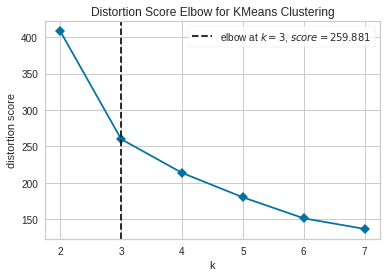

In [47]:
kmeans = KElbowVisualizer(model,k=clusters, metric='distortion',timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2. Sillhouette Score

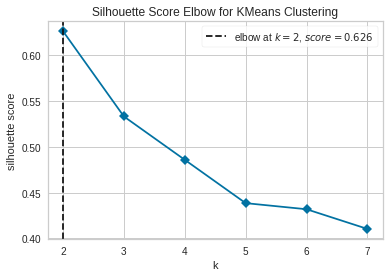

In [48]:
kmeans = KElbowVisualizer(model,k=clusters, metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show()

### 7.2.1. Silhouette Analysis

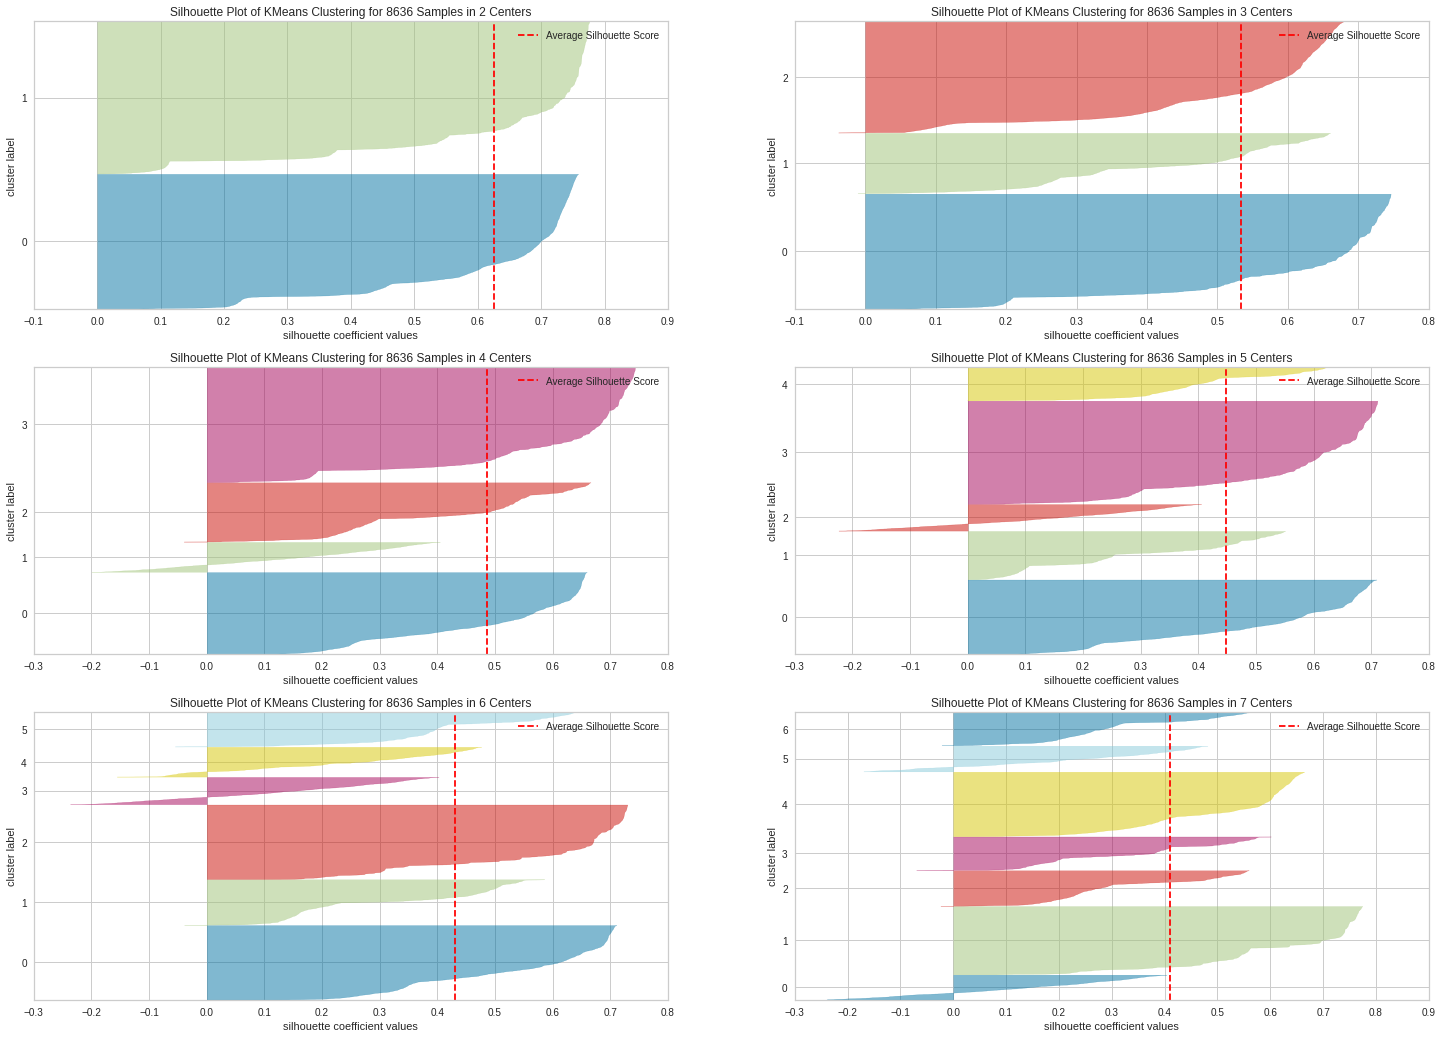

In [49]:
fig, ax = plt.subplots(3,2,figsize=(25,18))

for k in clusters:
  km = KMeans(n_clusters=k,init='random',n_init=10,max_iter=100,random_state=101)
  q, mod = divmod(k,2)

  visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
  visualizer.fit(X)
  visualizer.finalize()

## 7.3. Davies Bouldin Score

In [50]:
davies_list = []

for k in clusters:
  # model definition
  kmeans_model = KMeans(n_clusters=k,random_state=101)

  # model training
  kmeans_model.fit(X)

  # model predict
  labels = kmeans_model.predict(X)

  # model performance
  dav = m.davies_bouldin_score(X, labels)

  davies_list.append(dav)

Text(0, 0.5, 'Davies Boulding Score')

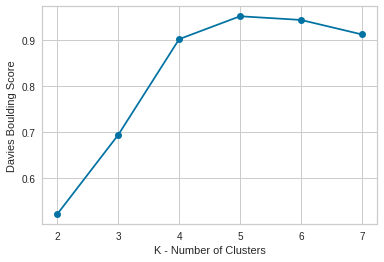

In [51]:
plt.plot(clusters, davies_list,marker='o')
plt.xlabel('K - Number of Clusters')
plt.ylabel('Davies Boulding Score')

# 8. Model Training

## 8.1. K-Means

In [52]:
# Model Definition
k = 3
kmeans = KMeans(init='random',n_clusters=k,random_state=101)

# Model Training
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [53]:
# WWS (Within-Cluster Sum of Square)
print('WWS value: {:.2f}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {:.2f}'.format(m.silhouette_score(X,labels)))

# Davies Bouldin Score
print('Davies Boulding Score: {:.2f}'.format(davies_list[1]))

WWS value: 259.88
SS value: 0.53
Davies Boulding Score: 0.69


# 9. Cluster Analysis

In [55]:
df9 = df2[['cust_id','purchases_frequency','purchases_trx','payments','credit_limit']].copy()
df9['cluster'] = labels
df9.head()

,cust_id,purchases_frequency,purchases_trx,payments,credit_limit,cluster
0,C10001,0.166667,2,201.802084,1000.0,0
1,C10002,0.000000,0,4103.032597,7000.0,0
2,C10003,1.000000,12,622.066742,7500.0,2
4,C10005,0.083333,1,678.334763,1200.0,0
5,C10006,0.666667,8,1400.057770,1800.0,1


## 9.1. Two-Dimentions Plot

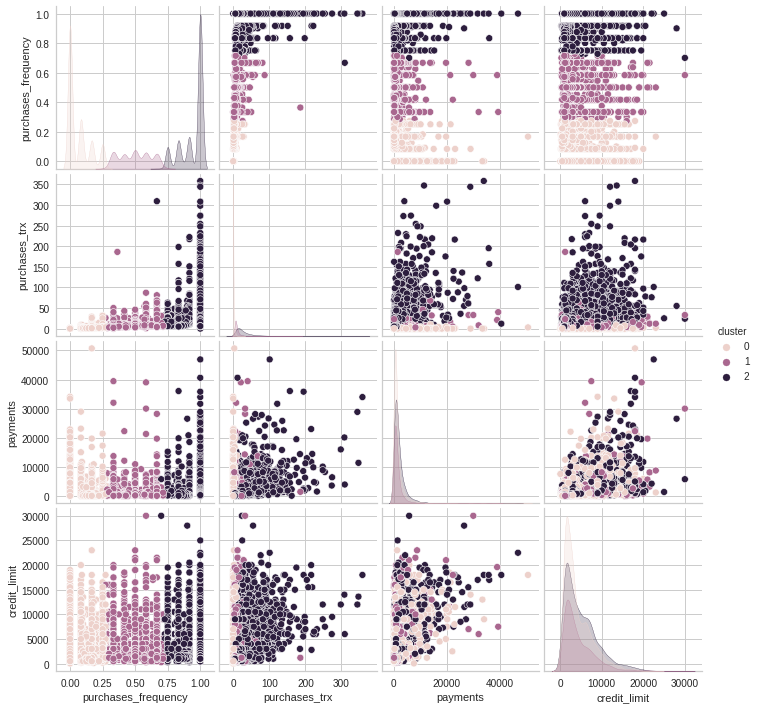

In [57]:
df_viz = df9.drop('cust_id',axis=1)
sns.pairplot(df_viz,hue='cluster')

## 9.2. UMAP

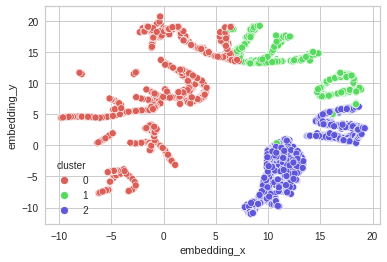

In [60]:
# Quciker from larger datasets but more difficult to visualize
# Change n_neighbors to see something similar to a local structure (\/) ou global structure (/\)
reducer = umap.UMAP(n_neighbors=20,random_state=101)
embedding = reducer.fit_transform(X)

# Embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# Plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',data=df_viz,hue='cluster',palette=sns.color_palette('hls',n_colors=len(df_viz['cluster'].unique())))

## 9.3. t-SNE

## 9.4. Cluster Profile

In [61]:
# Number of Customers
df_cluster = df9[['cust_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = round(100*(df_cluster['cust_id']/df_cluster['cust_id'].sum()),2)

df_aux = df9[['purchases_frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_aux, how='inner',on='cluster')

df_aux = df9[['purchases_trx','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_aux, how='inner',on='cluster')

df_aux = df9[['payments','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_aux, how='inner',on='cluster')

df_aux = df9[['credit_limit','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_aux, how='inner',on='cluster')

In [62]:
df_cluster

,cluster,cust_id,perc_customer,purchases_frequency,purchases_trx,payments,credit_limit
0,0,3470,40.18,0.064072,1.157349,1553.532998,4089.834163
1,1,1825,21.13,0.498829,10.207671,1429.089564,4338.820396
2,2,3341,38.69,0.943059,32.080814,2218.468994,5071.148268


### Cluster 01
- Number of Customers: **3341** (38.69% of customers)
- Frequency of Purchases (from 0 to 1): **0.94**
- Number of Purchases Transactions Made: **32**
- Amount of Payments Done: **$2214.27**

- Credit Card Limit: **U$5071.15**

### Cluster 02
- Number of Customers: **1825** (21.13% of customers)
- Frequency of Purchases (from 0 to 1): **0.49**
- Number of Purchases Transactions Made: **10**
- Amount of Payments Done: **$1429.08**

- Credit Card Limit: **U$4338.82**

### Cluster 03
- Number of Customers: **3470** (40.18% of customers)
- Frequency of Purchases (from 0 to 1): **0.06**
- Number of Purchases Transactions Made: **1**
- Amount of Payments Done: **$1553.53**

- Credit Card Limit: **U$4089.83**

# 10. Deploy to Production